In [67]:
import pandas as pd
import os
import numpy as np
from obspy import read, Trace, Stream
from obspy.core import UTCDateTime
from obspy.clients.filesystem.sds import Client
from datetime import timedelta
import glob

In [50]:
stations: list[str] = [
    'VG.PSAG.00.EHZ',
    'VG.TMKS.00.EHZ',
]

In [51]:
bands: dict[str, list[float]] = {
    'VLP': [0.02, 0.2],
    'LP':[0.5, 4.0],
    'VT':[4.0, 18.0]
}

# Resample parameter
resample_rule: str = '10min'

In [52]:
start_date: str = "2017-10-01"
end_date: str = "2018-07-31"

In [53]:
current_dir: str = os.getcwd()
sds_directory: str = r"D:\Data\SDS"
output_directory: str = os.path.join(current_dir, "output")

rsam_directory: str = os.path.join(output_directory, "rsam")
os.makedirs(rsam_directory, exist_ok=True)

figures_directory: str = os.path.join(output_directory, "figures")
os.makedirs(figures_directory, exist_ok=True)

client = Client(sds_directory)

In [ ]:
def get_dates(start: str, end: str) -> pd.DatetimeIndex:
    return pd.date_range(start, end, freq="D")

In [ ]:
dates: list[UTCDateTime] = [UTCDateTime(date) for date in get_dates(start_date, end_date)]
streams: dict[str, Stream] = {}

In [ ]:
def fill_streams(station: str, date: UTCDateTime)-> Stream:
       
    _network, _station, _location, _channel = station.split('.')
        
    stream = client.get_waveforms(
        network = _network,
        station = _station,
        location = _location,
        channel = _channel,
        starttime = date,
        endtime= date + timedelta(days=1)
    )
    
    # Check if stream is not empty (files not found)
    # Return empty Stream if files are not found
    if stream.count():           
        return stream
    else:
        print("⚠️ {} :: File(s) not found!".format(date.strftime('%Y-%m-%d')))
        return Stream()

In [ ]:
class RSAM:
    def __init__(self, stream: Stream=None, resample: str='10m', filter: list[float]=None,
                 bands: dict[str, list[float]] = None, corners=4):
            
        if bands is None:
            bands: dict[str, list[float]] = {
                'VLP': [0.02, 0.2], 
                'LP': [0.5, 4.0], 
                'VT': [4.0, 18.0]
            }
        
        self.resample = resample
        self.bands: dict[str, list[float]] = bands
        self.metrics: list[str] = ['min', 'max', 'mean', 'median', 'rms'] 
        self.dataframes: dict[str, pd.DataFrame] = {}
        
        for tr in stream:
            date_string = tr.stats.starttime.strftime('%Y-%m-%d')
            print("⌚ Processing {} for {}".format(date_string, tr.id))
            df = pd.DataFrame()
            tr = tr.detrend(type='demean')
            
            if filter:
                tr = tr.filter('bandpass', freqmin=filter[0], 
                               freqmax=filter[1], corners=corners)
            
            series = self.trace_to_series(tr, resample)
            df['min'] = series.min()
            df['mean'] = series.mean()
            df['max'] = series.max()
            df['median'] = series.max()
            df['rms'] = series.std()
            
            if bands:
                for band in bands:
                    df[band] = RSAM.calculate_per_band(
                        bands[band], tr, resample=resample, corners=corners).mean()
                    
                if 'LP' in bands and 'VT' in bands:
                    df['f_ratio'] = np.log2(df['VT'] / df['LP'])
            
            self.dataframes[tr.id] = df
    
    def save(self, csv_location: str=None)-> str:
        for station, df in self.dataframes.items():
            date = df.first_valid_index().strftime('%Y-%m-%d')
            
            csv_dir: str = os.path.join(csv_location, station, self.resample)
            os.makedirs(csv_dir, exist_ok=True)
            
            csv_location = os.path.join(csv_dir, '{}_{}.csv'.format(station, date))
            
            # Saving to CSV
            print("💾 Saving to {}".format(csv_location))
            df.to_csv(csv_location)
            
            # Return CSV location
            return csv_location
    
    @staticmethod
    def calculate_per_band(frequencies: list[float], trace: Trace, resample=None, corners=4) -> pd.Series:
        trace = trace.filter('bandpass', freqmin=frequencies[0], 
                             freqmax=frequencies[-1], corners=corners)
        return RSAM.trace_to_series(trace, resample)
            
    @staticmethod
    def trace_to_series(trace: Trace, resample=None) -> pd.Series:
        index_time = pd.date_range(
            start = trace.stats.starttime.datetime,
            periods = trace.stats.npts,
            freq = "{}ms".format(trace.stats.delta*1000)
        )
        
        _series = pd.Series(
            data=np.abs(trace.data),
            index=index_time,
            name='amplitude',
            dtype=trace.data.dtype)
        
        _series.index.name = 'datetime'
        
        if resample:
            return _series.resample(resample)
        
        return _series
    
    @staticmethod
    def trace_to_dataframe(trace: Trace)-> pd.DataFrame:
        return RSAM.trace_to_series(trace).to_frame()
            
        

In [86]:
def concatenate_csv(station: str) -> str:
    df_list: list = []
    
    csv_files: list[str] = glob.glob(os.path.join(
        rsam_directory, station, resample_rule, "*.csv"))
    
    for csv in csv_files:
        df = pd.read_csv(csv)
        df_list.append(df)
        
    big_df = pd.concat(df_list, ignore_index=True)
    big_df = big_df.dropna()
    big_df = big_df.loc[~big_df.index.duplicated(), :]
    
    combined_csv_files: str = os.path.join(rsam_directory, station, "combined_{}.csv".format(station))
    
    columns = ['datetime', 'min', 'mean', 'max', 'median', 'rms', 'VLP', 'LP', 'VT','f_ratio']
    
    big_df.to_csv(combined_csv_files, index=False, columns=columns)
    return combined_csv_files

# Running and save RSAM

In [ ]:
csv_files: dict[str, list[str]] = {}

for station in stations:
    
    csv_files[station]: list[str] = []

    for date in dates:
        date_string = date.strftime('%Y-%m-%d')
        streams[date_string]: Stream = fill_streams(station, date)

        if streams[date_string].count():
            rsam = RSAM(streams[date_string], resample=resample_rule)
            csv_files[station].append(rsam.save(rsam_directory))

In [85]:
for _station in stations:
    print(concatenate_csv(_station))

D:\Projects\dsar\output\rsam\VG.PSAG.00.EHZ\combined_VG.PSAG.00.EHZ.csv
D:\Projects\dsar\output\rsam\VG.TMKS.00.EHZ\combined_VG.TMKS.00.EHZ.csv


# Plot RSAM

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [82]:
# start date, end date of eruption
continous_eruptions: list[list[str]] = [
    ['2017-11-21', '2017-11-29'],
    ['2018-06-27', '2018-07-16'],
    ['2018-07-24', '2018-07-27'],
]

single_eruptions: list[str] = [
    '2017-11-25',
    '2017-11-26',
    '2017-11-27',
    '2017-11-29',
    '2017-12-08',
    '2017-12-09',
    '2017-12-10',
    '2017-12-11',
    '2017-12-12',
    '2017-12-23',
    '2017-12-24',
    '2017-12-26',
    '2017-12-28',
    '2018-01-01',
    '2018-01-03',
    '2018-01-11',
    '2018-01-15',
    '2018-01-17',
    '2018-01-18',
    '2018-01-19',
    '2018-01-20',
    '2018-01-22',
    '2018-01-23',
    '2018-01-24',
    '2018-02-13',
    '2018-03-11',
    '2018-03-26',
    '2018-04-06',
    '2018-04-15',
    '2018-04-30',
    '2018-05-19',
    '2018-05-29',
    '2018-06-10',
    '2018-06-13',
    '2018-06-15',
    '2018-06-27',
    '2018-07-02',
    '2018-07-03',
    '2018-07-04',
    '2018-07-05',
    '2018-07-06',
    '2018-07-08',
    '2018-07-09',
    '2018-07-11',
    '2018-07-13',
    '2018-07-15',
    '2018-07-16',
    '2018-07-21',
    '2018-07-24',
    '2018-07-25',
    '2018-07-27']

0 VG.PSAG.00.EHZ
1 VG.TMKS.00.EHZ


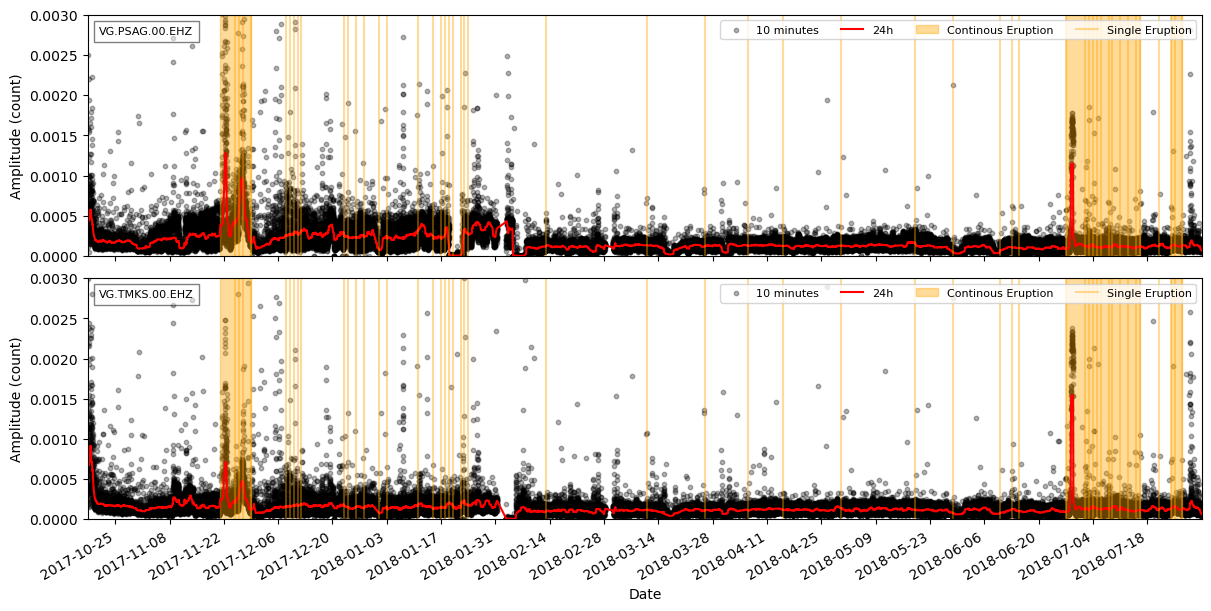

In [94]:
fig, axs = plt.subplots(nrows=len(stations), ncols=1, figsize=(12, 3*len(stations)),
                        layout="constrained", sharex=True)

for index_key, _station in enumerate(stations):
    print(index_key, _station)
    df = pd.read_csv(os.path.join(rsam_directory, _station, 'combined_{}.csv'.format(_station)), 
             index_col='datetime', parse_dates=True)
    
    df['VT_24h'] = df['VT'].rolling('24h', center=True).median()

    axs[index_key].scatter(df.index, df.VT, c= 'k', alpha=0.3, s=10, label='10 minutes')
    axs[index_key].plot(df.index, df.VT_24h, c='red', label='24h', alpha=1)
    
    axs[index_key].set_ylabel('Amplitude (count)')

    # Plot label only for the last subplot
    if index_key == (len(stations)-1):
        axs[index_key].set_xlabel('Date')
        
    axs[index_key].xaxis.set_major_locator(mdates.DayLocator(interval=14))
    axs[index_key].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[index_key].set_ylim(0,0.003)
    axs[index_key].set_xlim(df.first_valid_index(), df.last_valid_index())
    
    axs[index_key].annotate(
        text=_station,
        xy=(0.01, 0.92),
        xycoords='axes fraction',
        fontsize='8',
        bbox=dict(facecolor='white', alpha=0.5)
    )
    
    # Plotting continous eruptions
    for key, continous in enumerate(continous_eruptions):
        # continous[0] = start date of eruption
        # continous[1] = end date of eruption 
        axs[index_key].axvspan(datetime.strptime(continous[0], '%Y-%m-%d'), 
                               datetime.strptime(continous[1], '%Y-%m-%d'), 
                               alpha=0.4, color='orange', label="_"*key+'Continous Eruption')
    
    # Plotting single eruptions
    for key, date in enumerate(single_eruptions):
        axs[index_key].axvline(datetime.strptime(date, '%Y-%m-%d'), 
                               alpha=0.4, color='orange', label =  "_"*key + 'Single Eruption')
    # Add legend    
    axs[index_key].legend(loc='upper right', fontsize='8', ncol=4)
    
    # Rotate x label
    for label in axs[index_key].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')    